# Set up

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, sampler
from tqdm import tqdm

C:\Users\Asus\AppData\Local\Temp\ipykernel_512\1924793792.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load Data

In [2]:
X_train, y_train = torch.load("data/brats_train.pt")
X_val, y_val = torch.load("data/brats_val.pt")
X_test, y_test = torch.load("data/brats_test.pt")

# Preprocess

In [3]:
class BraTSDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]  # (C, H, W), already normalized
        mask = self.y[idx]  # (H, W)

        if torch.any(mask > 3):
            print(f"Sample {idx} has label > 3. Clamping.")
            mask = torch.clamp(mask, 0, 3)

        if self.transform:
            img = self.transform(img)

        return img, mask


In [4]:
train_dataset = BraTSDataset(X_train, y_train)
test_dataset = BraTSDataset(X_test, y_test)

img, mask = train_dataset[0]
print(f'Image shape: {img.shape}, Mask shape: {mask.shape}')  # (B, C, H, W)

Image shape: torch.Size([3, 128, 128]), Mask shape: torch.Size([128, 128])


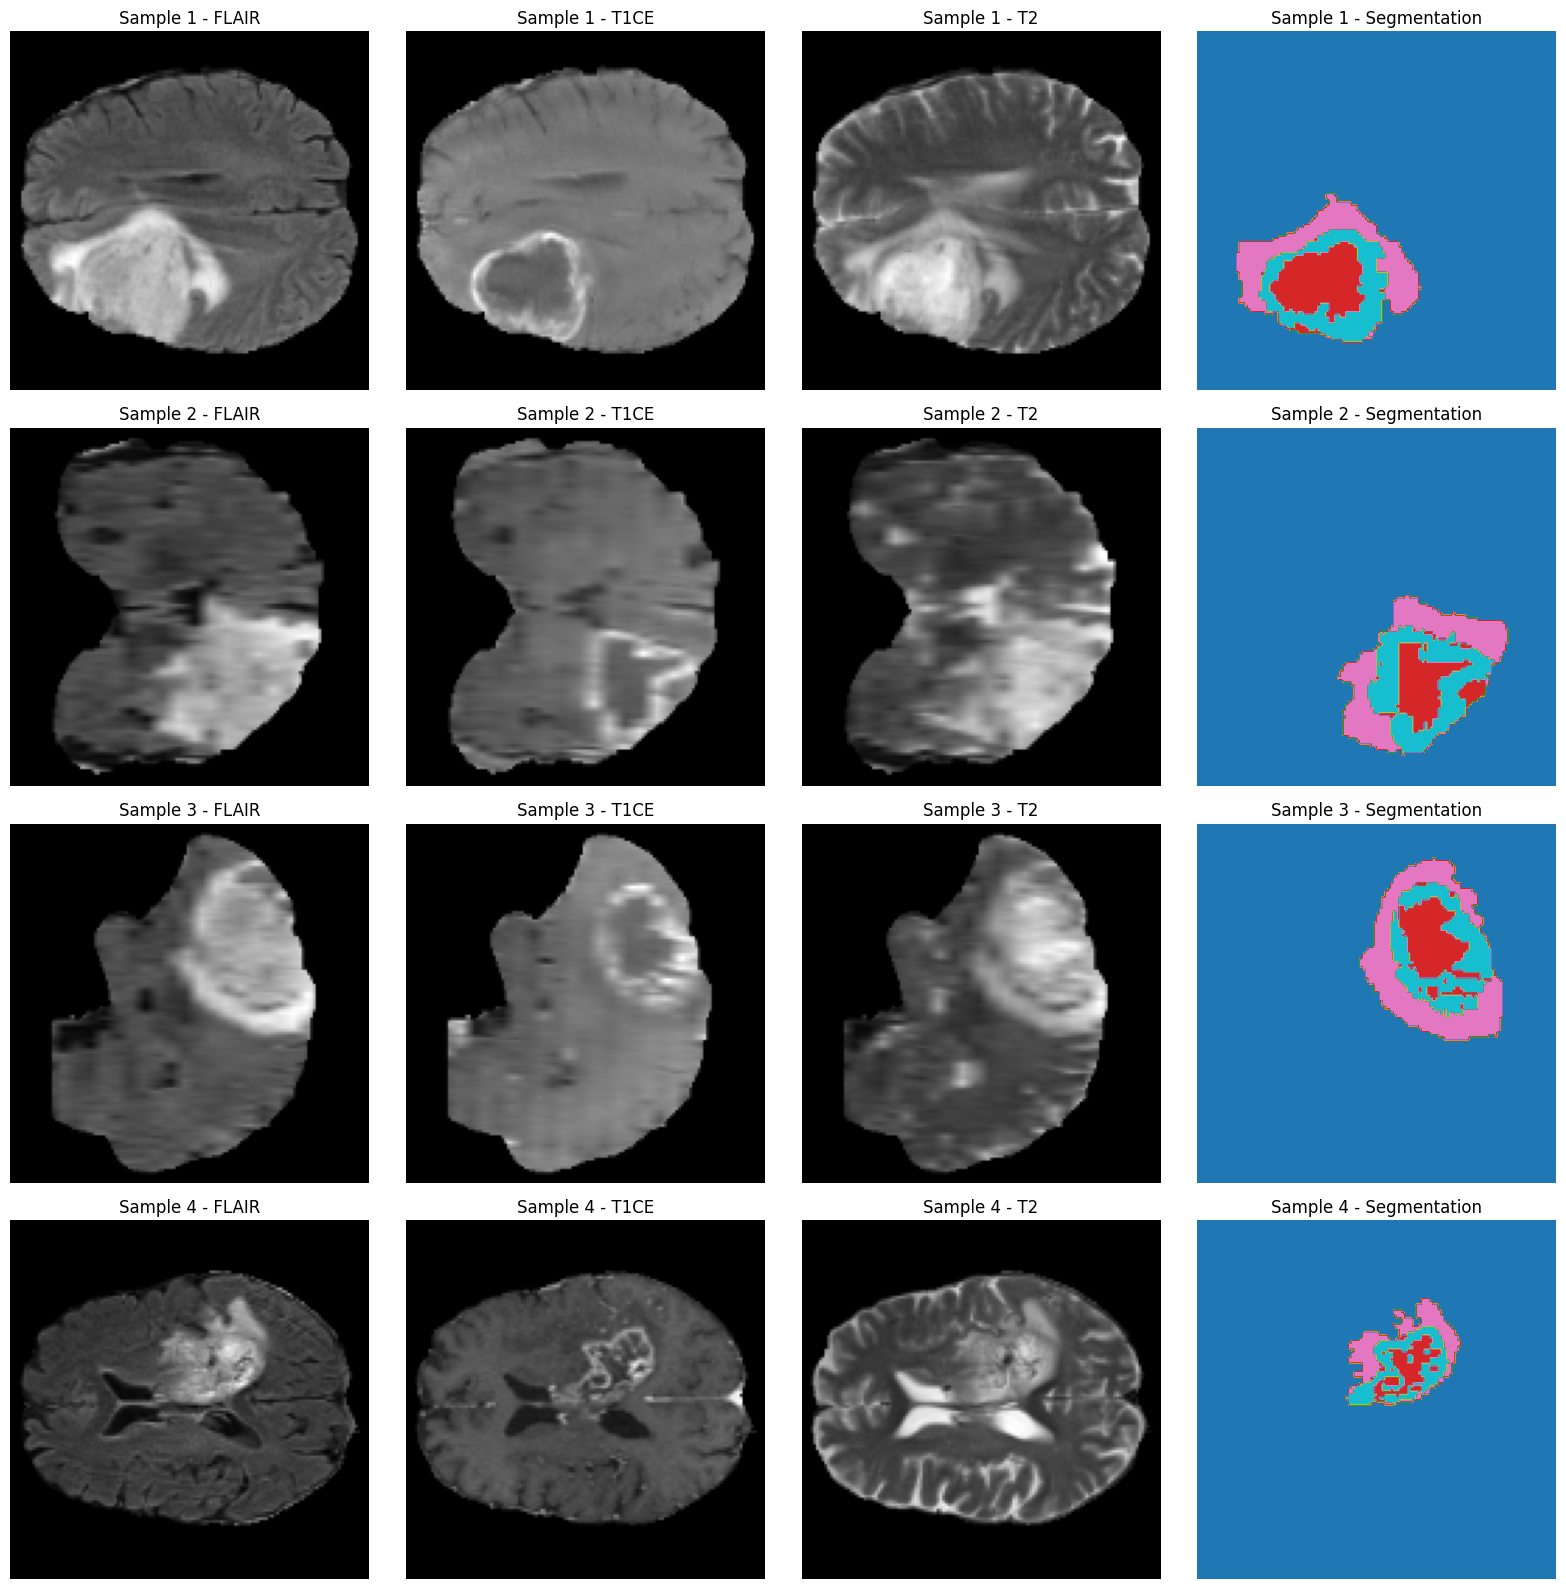

In [5]:
def plot_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))  # 3 inputs + 1 mask

    for i in range(num_samples):
        img, mask = dataset[i] # img: (3, H, W), mask: (H, W)
        img = img.cpu().numpy()
        mask = mask.cpu().numpy()

        flair = img[0]
        t1ce = img[1]
        t2 = img[2]

        axes[i, 0].imshow(flair, cmap='gray')
        axes[i, 0].set_title(f'Sample {i+1} - FLAIR')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(t1ce, cmap='gray')
        axes[i, 1].set_title(f'Sample {i+1} - T1CE')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(t2, cmap='gray')
        axes[i, 2].set_title(f'Sample {i+1} - T2')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(mask, cmap=ListedColormap(['black', 'red', 'green', 'yellow']))
        axes[i, 3].set_title(f'Sample {i+1} - Segmentation')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Plot samples from the training dataset
plot_samples(train_dataset, num_samples=4)

# UNet++

In [207]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = x.float()
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out


class NestedUNet(nn.Module):
    def __init__(self, num_classes, in_channels, deep_supervision=True):
        super(NestedUNet, self).__init__()
        out_channels = [64, 128, 256, 512, 1024]
        self.deep_supervision = deep_supervision

        # Backbone
        self.conv0_0 = ConvBlock(in_channels, out_channels[0], out_channels[0])
        self.conv1_0 = ConvBlock(out_channels[0], out_channels[1], out_channels[1])
        self.conv2_0 = ConvBlock(out_channels[1], out_channels[2], out_channels[2])
        self.conv3_0 = ConvBlock(out_channels[2], out_channels[3], out_channels[3])
        self.conv4_0 = ConvBlock(out_channels[3], out_channels[4], out_channels[4])

        # Skip pathways
        self.conv0_1 = ConvBlock(out_channels[0] + out_channels[1], out_channels[0], out_channels[0])
        self.conv1_1 = ConvBlock(out_channels[1] + out_channels[2], out_channels[1], out_channels[1])
        self.conv2_1 = ConvBlock(out_channels[2] + out_channels[3], out_channels[2], out_channels[2])
        self.conv3_1 = ConvBlock(out_channels[3] + out_channels[4], out_channels[3], out_channels[3])

        self.conv0_2 = ConvBlock(out_channels[0]*2 + out_channels[1], out_channels[0], out_channels[0])
        self.conv1_2 = ConvBlock(out_channels[1]*2 + out_channels[2], out_channels[1], out_channels[1])
        self.conv2_2 = ConvBlock(out_channels[2]*2 + out_channels[3], out_channels[2], out_channels[2])

        self.conv0_3 = ConvBlock(out_channels[0]*3 + out_channels[1], out_channels[0], out_channels[0])
        self.conv1_3 = ConvBlock(out_channels[1]*3 + out_channels[2], out_channels[1], out_channels[1])

        self.conv0_4 = ConvBlock(out_channels[0]*4 + out_channels[1], out_channels[0], out_channels[0])

        # Pooling and upsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Classifier
        if self.deep_supervision:
            self.final1 = nn.Conv2d(out_channels[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(out_channels[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(out_channels[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(out_channels[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(out_channels[0], num_classes, kernel_size=1)

    def forward(self, x):
        # Backbone
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        # Input = previous conv + upsample lower conv
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up_sample(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up_sample(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up_sample(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up_sample(x4_0)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up_sample(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up_sample(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up_sample(x3_1)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up_sample(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up_sample(x2_2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up_sample(x1_3)], 1))

        if self.deep_supervision:
            out1 = self.final1(x0_1)
            out2 = self.final2(x0_2)
            out3 = self.final3(x0_3)
            out4 = self.final4(x0_4)
            # print(out1.shape, out2.shape, out3.shape, out4.shape)
            out1 = F.interpolate(out1, size=(128, 128), mode='bilinear', align_corners=False)
            out2 = F.interpolate(out2, size=(128, 128), mode='bilinear', align_corners=False)
            out3 = F.interpolate(out3, size=(128, 128), mode='bilinear', align_corners=False)
            out4 = F.interpolate(out4, size=(128, 128), mode='bilinear', align_corners=False)
            # print(out1.shape, out2.shape, out3.shape, out4.shape)
            output = torch.stack([out1, out2, out3, out4])
        else:
            output = torch.stack([self.final(x0_4)])
        return output

# Loss

In [208]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.eps = torch.finfo(torch.float32).eps

    def forward(self, predict, target):
        predict = F.softmax(predict, dim=1)
        num_classes = predict.shape[1]
        dice = 0.0

        for c in range(num_classes):
            pred_flat = predict[:, c, :, :].contiguous().view(-1)
            target_flat = (target == c).float().view(-1)
            intersection = torch.sum(pred_flat * target_flat)
            union = torch.sum(pred_flat) + torch.sum(target_flat)
            dice_class = (2 * intersection + self.eps) / (union + self.eps)
            dice += 1 - dice_class

        return dice / num_classes


class DiceCELoss(nn.Module):
    def __init__(self, dice_weight=0.5, class_weights=None):
        super(DiceCELoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights) if class_weights is not None else nn.CrossEntropyLoss()
        self.dice_weight = dice_weight

    def forward(self, predict, target):
        dice = self.dice_loss(predict.float(), target.float())
        ce_target = F.one_hot(target.squeeze(1).long(), num_classes=4).permute(0,3,1,2)
        ce = self.ce_loss(predict.float(), ce_target.float())
        return self.dice_weight * dice + (1 - self.dice_weight) * ce

In [209]:
def IoU(pred_masks, true_masks):
    total_iou = 0
    num_classes = pred_masks.shape[1]
    pred_probs = torch.softmax(pred_masks.float(), dim=1)

    for class_idx in range(num_classes):
        pred_mask = (torch.argmax(pred_probs.float(), dim=1) == class_idx).float()
        # true_mask = (true_masks[:, 0, :, :] == class_idx).float()
        true_mask = (true_masks == class_idx).float()
        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()
        iou = intersection / union if union != 0 else 1  # Correct empty prediction
        total_iou += iou

    return total_iou / num_classes

In [210]:
def deep_supervision_loss(predicts, targets, criterion, ds_weights):
    loss = 0.0
    for i in range(predicts.shape[0]):
        loss += criterion(predicts[i], targets) * ds_weights[i]
    return loss / predicts.shape[0]

# Training and Testing

In [220]:
def train(model, train_loader, num_epochs, optimizer, criterion, ds_weights, device, dtype, save_path, print_every=None):
    try:
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0.0
            total_iou = 0.0
            num_samples = 0

            for batch_idx, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = batch
                inputs = inputs.to(device, dtype=dtype)
                labels = labels.to(device, dtype=dtype)

                optimizer.zero_grad()
                out = model(inputs)
                loss = deep_supervision_loss(out, labels, criterion, ds_weights)
                loss.backward()
                optimizer.step()

                with torch.no_grad():  # Disable gradient calculation\
                    weighted_out = torch.sum(out * ds_weights.view(-1, 1, 1, 1, 1), dim=0)
                    iou = IoU(weighted_out, labels)
                    total_iou += iou * inputs.size(0)
                    num_samples += inputs.size(0)

                total_loss += loss.item() * inputs.size(0)

                if print_every is not None and batch_idx % print_every == 0:
                    print('  Step [{}/{}], Loss: {:.4f}, IoU: {:.4f}'.format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item(), iou))

            average_loss = total_loss / num_samples
            average_iou = total_iou / num_samples
            print('  Average Loss: {:.4f}, Average IoU: {:.4f}'.format(average_loss, average_iou))

        torch.save(model, save_path)

    except Exception as e:
        print(e)
        torch.save(model, save_path)

In [221]:
# def test(model, val_loader, criterion, device, dtype):
#     model.eval()
#     total_loss = 0.0
#     total_iou = 0.0
#     num_samples = 0

#     with torch.no_grad():
#         for batch_idx, batch in enumerate(val_loader):
#             inputs, labels = batch
#             inputs = inputs.to(device, dtype=dtype)
#             labels = labels.to(device, dtype=dtype)

#             out = model(inputs)
#             loss = criterion(out, labels)
#             iou = IoU(out, labels)

#             total_iou += iou * inputs.size(0)
#             total_loss += loss.item() * inputs.size(0)
#             num_samples += inputs.size(0)

#         average_loss = total_loss/num_samples
#         average_iou = total_iou/num_samples

#         print('Test Loss: {:.4f}, Test IoU: {:.4f}'.format(average_loss, average_iou))

In [222]:
def estimate_class_weights(y_train, num_classes):
    y_flat = y_train.view(-1)
    counts = torch.bincount(y_flat, minlength=num_classes).float()
    total = counts.sum()
    weights = total / counts
    return weights / weights.sum()

print(f"Train class weights ~ {estimate_class_weights(y_train, 4)}")
print(f"Test class weights  ~ {estimate_class_weights(y_test, 4)}")

Train class weights ~ tensor([0.0109, 0.3839, 0.1892, 0.4160])
Test test weights   ~ tensor([0.0106, 0.2956, 0.1751, 0.5187])


In [236]:
# Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print_every = None

input_channels = 3
num_classes = 4
class_weights = estimate_class_weights(y_train, num_classes).to(device)
ds_weights = torch.tensor([0.03, 0.07, 0.15, 0.75]).to(device)
# ds_weights = torch.tensor([1]).to(device)
dice_weight = 0.5
learning_rate = 0.001
batch_size = 16
num_epochs = 30

save_path = f'checkpoints/unet++ds_dce{dice_weight:.0e}_invfreqw_adam{learning_rate:.0e}_batch{batch_size}_epoch{num_epochs}.pth'.replace('+0', '').replace('-0', '-')
model = NestedUNet(num_classes, input_channels, deep_supervision=True)
criterion = DiceCELoss(dice_weight=dice_weight, class_weights=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)

print(save_path)

checkpoints/unet++_dce5e-1_invfreqw_adam1e-3_batch16_epoch50.pth


In [237]:
from torch.utils.data import Subset
train_subset = Subset(train_dataset, list(range(8)))
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train(model, train_loader, num_epochs, optimizer, criterion, ds_weights, device, dtype, save_path, print_every)

Epoch 1/50: 100%|██████████| 1/1 [00:07<00:00,  7.93s/it]


Average Loss: 0.1156, Average IoU: 0.0219


Epoch 2/50: 100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


Average Loss: 0.1098, Average IoU: 0.1403


Epoch 3/50: 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


Average Loss: 0.1052, Average IoU: 0.1910


Epoch 4/50: 100%|██████████| 1/1 [00:07<00:00,  7.69s/it]


Average Loss: 0.1020, Average IoU: 0.1951


Epoch 5/50: 100%|██████████| 1/1 [00:07<00:00,  7.72s/it]


Average Loss: 0.0986, Average IoU: 0.2247


Epoch 6/50: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]


Average Loss: 0.0945, Average IoU: 0.2591


Epoch 7/50: 100%|██████████| 1/1 [00:07<00:00,  7.71s/it]


Average Loss: 0.0924, Average IoU: 0.2642


Epoch 8/50: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]


Average Loss: 0.0905, Average IoU: 0.2773


Epoch 9/50: 100%|██████████| 1/1 [00:07<00:00,  7.96s/it]


Average Loss: 0.0890, Average IoU: 0.3011


Epoch 10/50: 100%|██████████| 1/1 [00:07<00:00,  7.68s/it]


Average Loss: 0.0873, Average IoU: 0.3469


Epoch 11/50: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]


Average Loss: 0.0861, Average IoU: 0.3879


Epoch 12/50: 100%|██████████| 1/1 [00:07<00:00,  7.66s/it]


Average Loss: 0.0848, Average IoU: 0.4161


Epoch 13/50: 100%|██████████| 1/1 [00:07<00:00,  7.74s/it]


Average Loss: 0.0838, Average IoU: 0.3907


Epoch 14/50: 100%|██████████| 1/1 [00:07<00:00,  7.67s/it]


Average Loss: 0.0826, Average IoU: 0.4220


Epoch 15/50: 100%|██████████| 1/1 [00:07<00:00,  7.96s/it]


Average Loss: 0.0817, Average IoU: 0.5302


Epoch 16/50: 100%|██████████| 1/1 [00:07<00:00,  7.70s/it]


Average Loss: 0.0808, Average IoU: 0.6044


Epoch 17/50: 100%|██████████| 1/1 [00:07<00:00,  7.74s/it]


Average Loss: 0.0797, Average IoU: 0.6473


Epoch 18/50: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]


Average Loss: 0.0788, Average IoU: 0.6965


Epoch 19/50: 100%|██████████| 1/1 [00:07<00:00,  7.75s/it]


Average Loss: 0.0779, Average IoU: 0.7157


Epoch 20/50: 100%|██████████| 1/1 [00:07<00:00,  7.68s/it]


Average Loss: 0.0769, Average IoU: 0.7194


Epoch 21/50: 100%|██████████| 1/1 [00:07<00:00,  7.71s/it]


Average Loss: 0.0759, Average IoU: 0.7464


Epoch 22/50: 100%|██████████| 1/1 [00:07<00:00,  7.66s/it]


Average Loss: 0.0752, Average IoU: 0.7592


Epoch 23/50: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]


Average Loss: 0.0741, Average IoU: 0.7667


Epoch 24/50: 100%|██████████| 1/1 [00:07<00:00,  7.65s/it]


Average Loss: 0.0732, Average IoU: 0.7741


Epoch 25/50: 100%|██████████| 1/1 [00:07<00:00,  7.70s/it]


Average Loss: 0.0725, Average IoU: 0.7891


Epoch 26/50: 100%|██████████| 1/1 [00:07<00:00,  7.69s/it]


Average Loss: 0.0717, Average IoU: 0.7688


Epoch 27/50: 100%|██████████| 1/1 [00:07<00:00,  7.71s/it]


Average Loss: 0.0708, Average IoU: 0.7774


Epoch 28/50: 100%|██████████| 1/1 [00:07<00:00,  7.68s/it]


Average Loss: 0.0698, Average IoU: 0.7930


Epoch 29/50: 100%|██████████| 1/1 [00:07<00:00,  7.73s/it]


Average Loss: 0.0688, Average IoU: 0.7991


Epoch 30/50: 100%|██████████| 1/1 [00:07<00:00,  7.67s/it]


Average Loss: 0.0679, Average IoU: 0.8018


Epoch 31/50: 100%|██████████| 1/1 [00:07<00:00,  7.74s/it]


Average Loss: 0.0668, Average IoU: 0.8133


Epoch 32/50: 100%|██████████| 1/1 [00:07<00:00,  7.65s/it]


Average Loss: 0.0659, Average IoU: 0.8203


Epoch 33/50: 100%|██████████| 1/1 [00:07<00:00,  7.69s/it]


Average Loss: 0.0650, Average IoU: 0.8055


Epoch 34/50: 100%|██████████| 1/1 [00:07<00:00,  7.66s/it]


Average Loss: 0.0640, Average IoU: 0.8181


Epoch 35/50: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]


Average Loss: 0.0630, Average IoU: 0.8145


Epoch 36/50: 100%|██████████| 1/1 [00:07<00:00,  7.71s/it]


Average Loss: 0.0621, Average IoU: 0.8152


Epoch 37/50: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]


Average Loss: 0.0611, Average IoU: 0.8234


Epoch 38/50: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]


Average Loss: 0.0600, Average IoU: 0.8316


Epoch 39/50: 100%|██████████| 1/1 [00:07<00:00,  7.70s/it]


Average Loss: 0.0590, Average IoU: 0.8205


Epoch 40/50: 100%|██████████| 1/1 [00:07<00:00,  7.65s/it]


Average Loss: 0.0576, Average IoU: 0.8378


Epoch 41/50: 100%|██████████| 1/1 [00:07<00:00,  7.71s/it]


Average Loss: 0.0567, Average IoU: 0.8397


Epoch 42/50: 100%|██████████| 1/1 [00:07<00:00,  7.65s/it]


Average Loss: 0.0557, Average IoU: 0.8357


Epoch 43/50: 100%|██████████| 1/1 [00:07<00:00,  7.86s/it]


Average Loss: 0.0544, Average IoU: 0.8464


Epoch 44/50: 100%|██████████| 1/1 [00:07<00:00,  7.69s/it]


Average Loss: 0.0539, Average IoU: 0.8328


Epoch 45/50: 100%|██████████| 1/1 [00:07<00:00,  7.78s/it]


Average Loss: 0.0554, Average IoU: 0.8233


Epoch 46/50: 100%|██████████| 1/1 [00:07<00:00,  7.68s/it]


Average Loss: 0.0556, Average IoU: 0.7448


Epoch 47/50: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]


Average Loss: 0.0528, Average IoU: 0.7905


Epoch 48/50: 100%|██████████| 1/1 [00:07<00:00,  7.75s/it]


Average Loss: 0.0522, Average IoU: 0.8039


Epoch 49/50: 100%|██████████| 1/1 [00:07<00:00,  7.75s/it]


Average Loss: 0.0506, Average IoU: 0.8243


Epoch 50/50: 100%|██████████| 1/1 [00:07<00:00,  7.71s/it]


Average Loss: 0.0498, Average IoU: 0.8234


# Visualize Segmentation Results

In [244]:
# Load the saved model
saved_model_path = 'checkpoints/unet++_dce5e-1_invfreqw_adam1e-3_batch16_epoch50.pth'
loaded_model = torch.load(saved_model_path)
loaded_model.eval()
loaded_model.to(device)

UNetPlusPlus(
  (conv0_0): ConvBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): ConvBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): ConvBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=

In [245]:
def calculate_metrics(model, dataloader, device=torch.device('cuda'), num_classes=4, eps=torch.finfo(torch.float32).eps):
    model.eval()
    total_iou = 0.0
    total_dice = 0.0
    num_samples = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.long)

            outputs = model(imgs)  # (N, B, C, H, W)
            weighted_out = torch.sum(outputs * ds_weights.view(-1, 1, 1, 1, 1), dim=0)
            pred_masks = torch.argmax(weighted_out, dim=1)  # (B, H, W)

            dice_sum = 0.0
            iou_sum = 0.0
            for c in range(num_classes):
                pred_cls = (pred_masks == c).float()
                true_cls = (masks == c).float()

                intersection = torch.sum(pred_cls * true_cls)
                union = torch.sum((pred_cls + true_cls) > 0)
                iou = (intersection + eps) / (union + eps)
                dice = (2. * intersection + eps) / (torch.sum(pred_cls) + torch.sum(true_cls) + eps)

                dice_sum += dice.item()
                iou_sum += iou.item()

            total_dice += dice_sum / num_classes
            total_iou += iou_sum / num_classes
            num_samples += 1

    return {
        'IoU': total_iou / num_samples,
        'Dice': total_dice / num_samples
    }

In [246]:
# Calculate metrics on the test set
vis_test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

metrics = calculate_metrics(loaded_model, vis_test_loader, device=device)
print(f"Test IoU: {metrics['IoU']:.4f}")
print(f"Test Dice: {metrics['Dice']:.4f}")

Test IoU: 0.2412
Test Dice: 0.3061


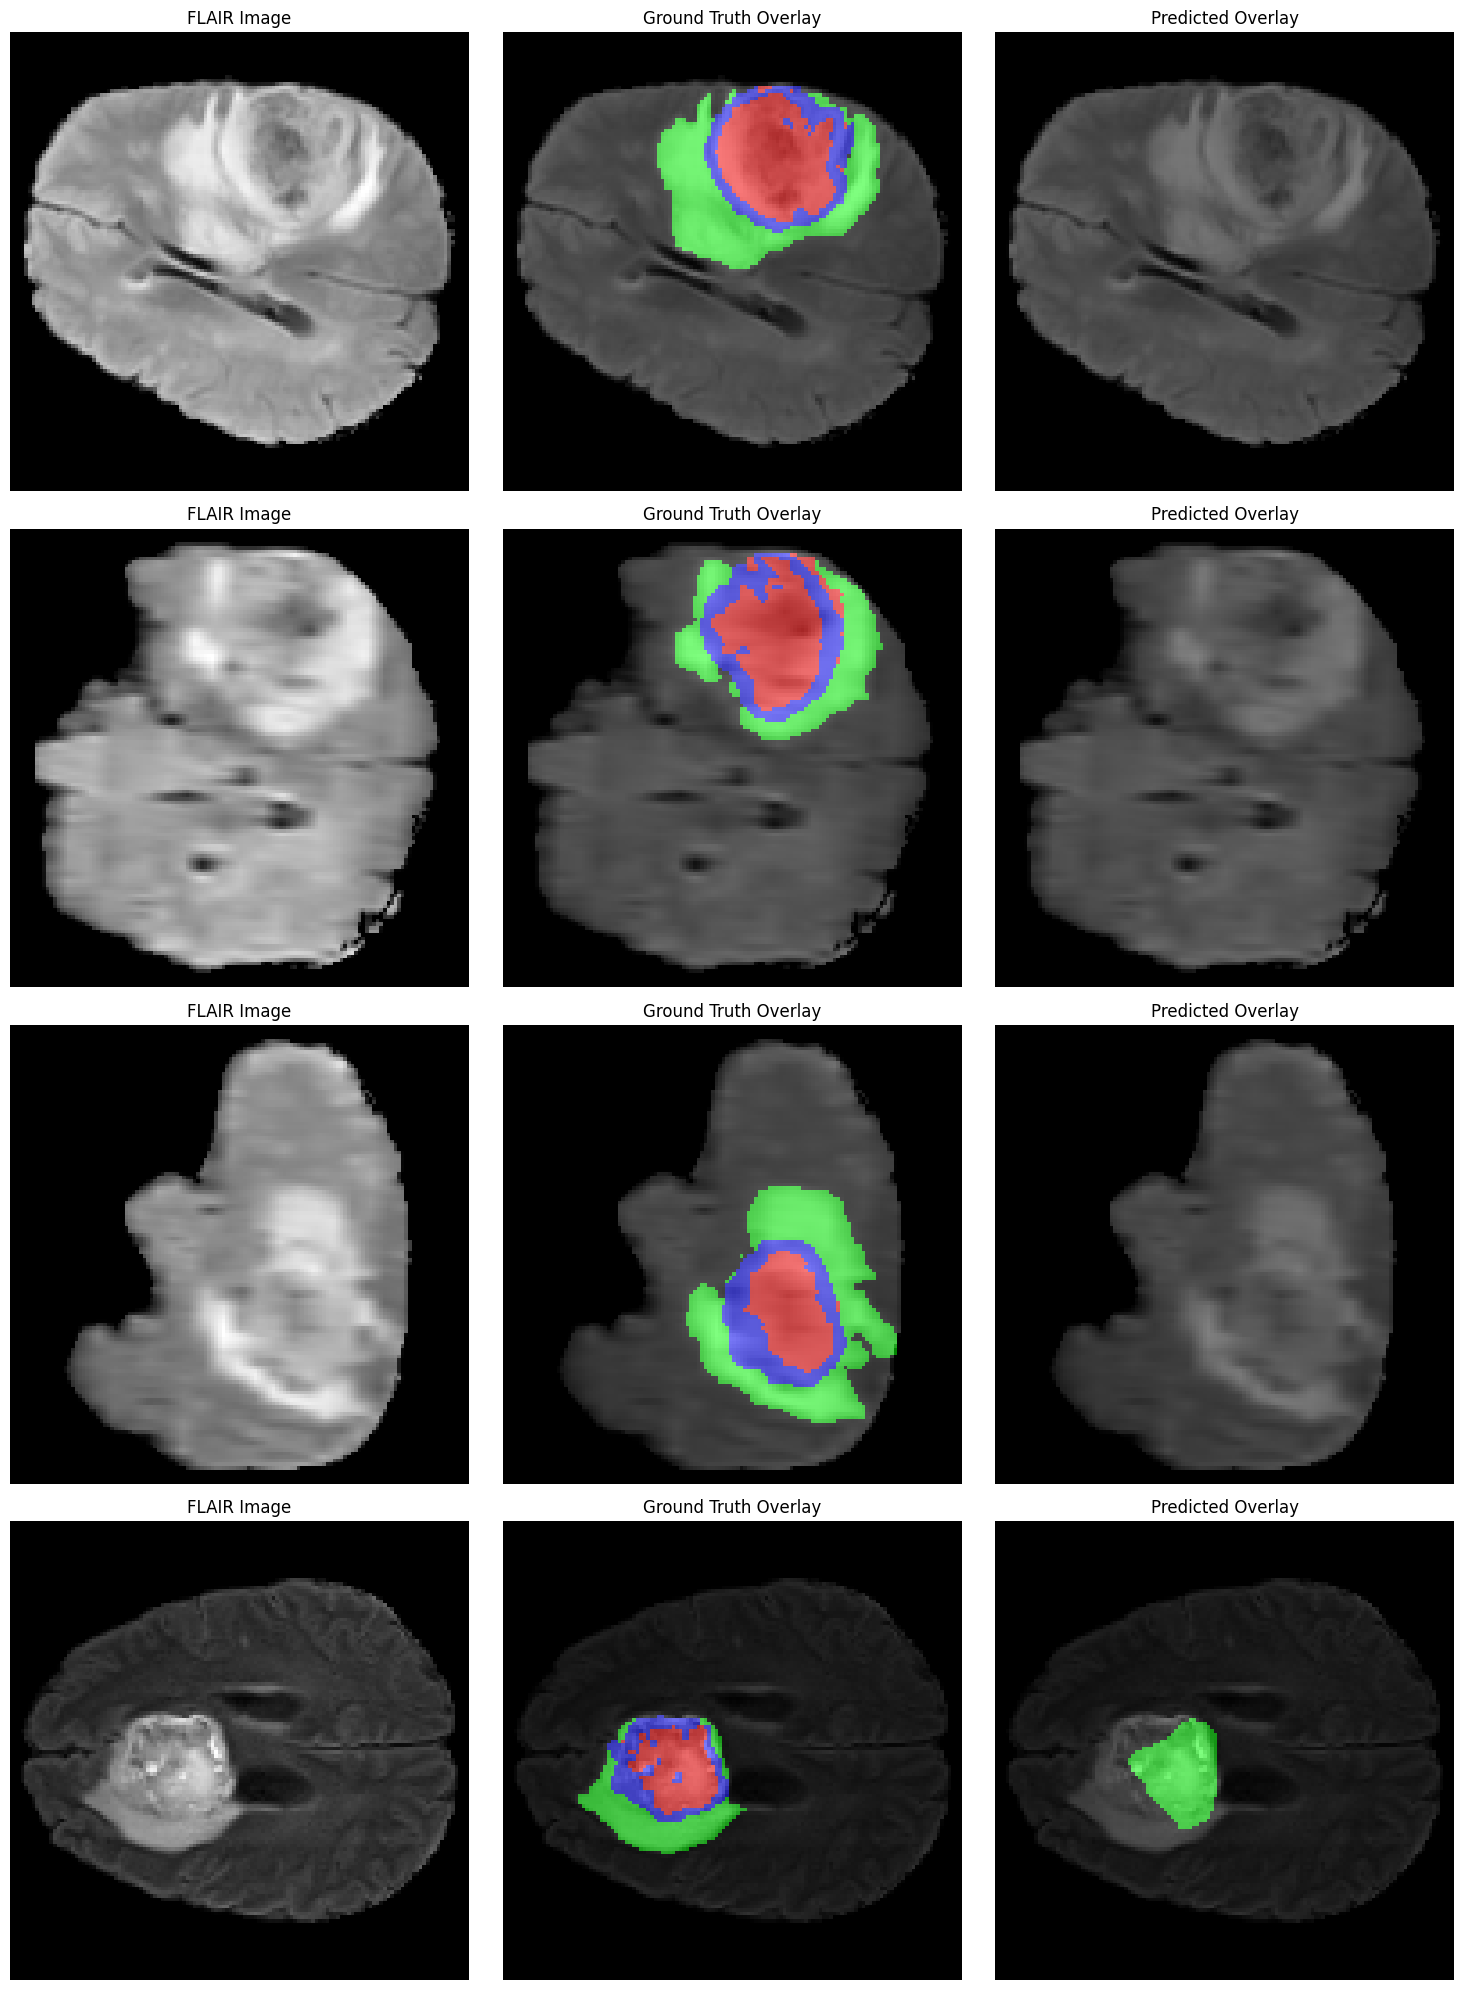

In [ ]:
# Visualize segmentation overlays
def visualize_segmentation_overlay(model, dataloader, num_samples=4, device=torch.device('cuda')):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    count = 0
    with torch.no_grad():
        for images, masks in dataloader:
            batch_size = images.size(0)
            for b in range(batch_size):
                if count >= num_samples:
                    break

                image = images[b].to(device).unsqueeze(0)  # [1, C, H, W]
                mask = masks[b].to(device)  # [H, W]

                outputs = model(image)
                weighted_out = torch.sum(outputs * ds_weights.view(-1, 1, 1, 1, 1), dim=0)

                pred_mask = torch.argmax(torch.softmax(weighted_out, dim=1), dim=1)[0].cpu().numpy()
                mask_np = mask.cpu().numpy()
                flair_np = image[0, 0].cpu().numpy()

                flair_np = (flair_np - flair_np.min()) / (flair_np.max() - flair_np.min() + 1e-5)
                flair_rgb = np.stack([flair_np]*3, axis=-1)

                cmap = ListedColormap(['black', 'red', 'green', 'yellow'])
                gt_overlay = 0.5 * flair_rgb + 0.5 * cmap(mask_np)[..., :3]
                pred_overlay = 0.5 * flair_rgb + 0.5 * cmap(pred_mask)[..., :3]

                # Plotting
                axes[count, 0].imshow(flair_np, cmap='gray')
                axes[count, 0].set_title("FLAIR Image")
                axes[count, 0].axis('off')

                axes[count, 1].imshow(gt_overlay)
                axes[count, 1].set_title("Ground Truth Overlay")
                axes[count, 1].axis('off')

                axes[count, 2].imshow(pred_overlay)
                axes[count, 2].set_title("Predicted Overlay")
                axes[count, 2].axis('off')

                count += 1
            if count >= num_samples:
                break

    plt.tight_layout()
    plt.show()



visualize_segmentation_overlay(loaded_model, vis_test_loader, num_samples=4, device=device)